<a href="https://colab.research.google.com/github/michalinahulak/alien_vs_predator_CV/blob/main/alien_vs_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project
The goal of this project is to build a model that can classify images of Aliens and Predators. This is a classic image classification problem, and we will use deep learning techniques to tackle it. We will use a dataset of images of Aliens and Predators, which will be split into a training and testing set. We will preprocess the images and apply data augmentation to increase the size of our training set. We will then build a convolutional neural network (CNN) to classify the images. We will evaluate our model on the testing set and use metrics such as accuracy, precision, recall, and F1-score to measure its performance.

# Imports

In [ ]:
!pip install gradio

In [ ]:
!pip install opendatasets

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import opendatasets as od
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping

import os
import gradio as gr
import requests
from PIL import Image
from io import BytesIO
import cv2

from keras.utils import image_dataset_from_directory

from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls -la '/content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator'

total 108438
-rw------- 1 root root 14823464 Apr 30 19:07 alien_predator.zip
-rw------- 1 root root  1468201 May 12 10:16 alien_vs_predator
drwx------ 2 root root     4096 Apr 30 20:25 alien_vs_predator_thumbnails
drwx------ 2 root root     4096 Apr 30 20:25 data
drwx------ 2 root root     4096 May 11 19:53 flagged
-rw------- 1 root root 94735120 May 11 19:22 predator_alien_model.h5


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator

/content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator


# Functions

In [ ]:
def plot_class_distribution(dataset_path, dataset_name):
    class_names = sorted(os.listdir(dataset_path))
    n_classes = len(class_names)
    class_dis = [len(os.listdir(dataset_path + '/' + name)) for name in class_names]
    fig = px.pie(names=class_names, 
                 values=class_dis, 
                 hole=0.3, 
                 color_discrete_sequence=["#1D3B2F", "#47077F"])
    fig.update_layout(title={'text': f"Class distribution in {dataset_name}", 'x':0.48},
                      width=500,
                      height=500)
    fig.show()

In [ ]:
def display_random_images(dataset):
    plt.figure(figsize=(5, 5))
    for images, labels in dataset.take(1):
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

In [ ]:
def apply_noise(image):
    image = tf.cast(image, tf.float32) / 255.0
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)
    noisy_image = tf.cast(noisy_image * 255, tf.uint8)
    return noisy_image

In [ ]:
def flip_image(image):
    flip = tf.random.uniform([], 0, 3, dtype=tf.int32)
    if flip == 0:
        return image
    elif flip == 1:
        return tf.image.flip_left_right(image)
    else:
        return tf.image.flip_up_down(image)

# Upload data

In [22]:
od.download(
    "https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michalina.hulak
Your Kaggle Key: ··········


ApiException: ignored

In [5]:
path_train = '/content/drive/MyDrive/Colab Notebooks/Codecool/alien vs predator/data/train'
path_val = '/content/drive/MyDrive/Colab Notebooks/Codecool/alien vs predator/data/validation'

In [6]:
batch_size = 6
img_height = 224
img_width = 224

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                 height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                   validation_split=0.2)

train_ds = train_datagen.flow_from_directory(directory=path_train,
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=True,
                                             subset = 'training')

val_ds = train_datagen.flow_from_directory(path_train,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    shuffle = False, 
                                                    class_mode = 'categorical',
                                                   subset = 'validation')

test_ds = train_datagen.flow_from_directory(directory=path_val,
                                           target_size=(img_height, img_width),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=True)

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
ds_train = image_dataset_from_directory(
    path_train,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width), 
    seed= 123
)

Found 694 files belonging to 2 classes.


In [ ]:
ds_val = image_dataset_from_directory(
    path_val,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width),
    seed=123
)

Found 200 files belonging to 2 classes.


# EDA

In [ ]:
class_names = ds_train.class_names

In [ ]:
plot_class_distribution(path_train, "ds_train")

In [ ]:
plot_class_distribution(path_val, "ds_val")

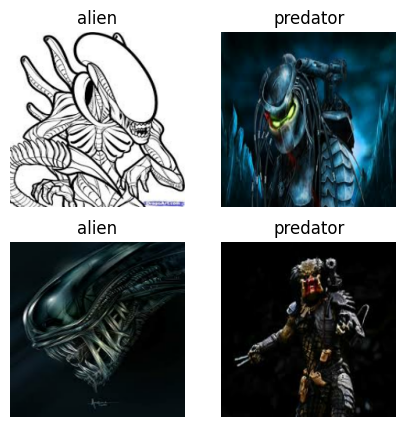

In [ ]:
display_random_images(dataset= ds_train)

## RandomContrast

In [ ]:
ds_train_augmented_contrast = ds_train.map(lambda x, y: (preprocessing.RandomContrast(0.5)(tf.image.rgb_to_grayscale(x)), y))

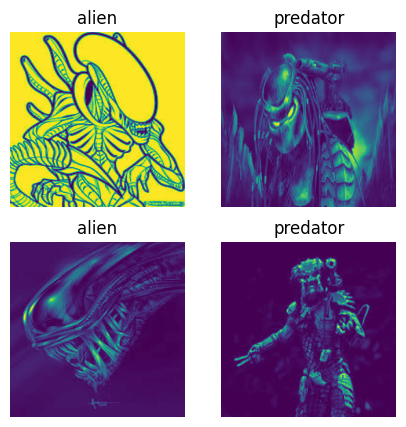

In [ ]:
display_random_images(ds_train_augmented_contrast)

## Grayscale

In [ ]:
ds_train_augmented_gray_rgb = ds_train_augmented_contrast.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

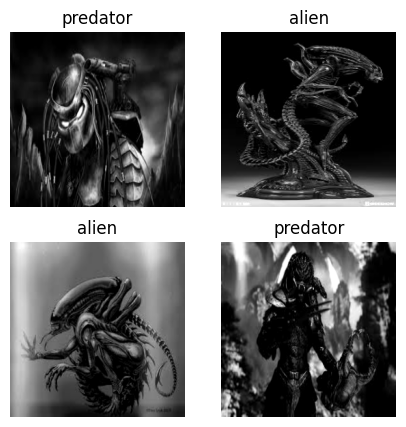

In [ ]:
display_random_images(ds_train_augmented_gray_rgb)

## With noise

In [ ]:
ds_train_noisy = ds_train.map(lambda x, y: (apply_noise(x), y))

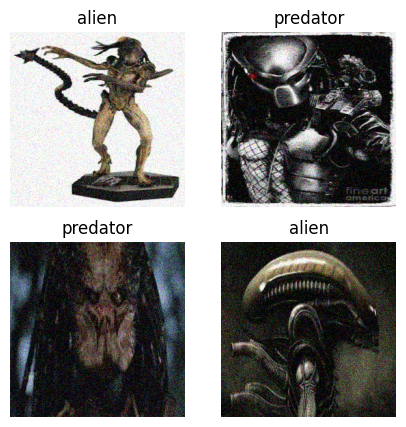

In [ ]:
display_random_images(ds_train_noisy)

## random flip

In [ ]:
ds_train_flipped = ds_train.map(lambda x, y: (flip_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

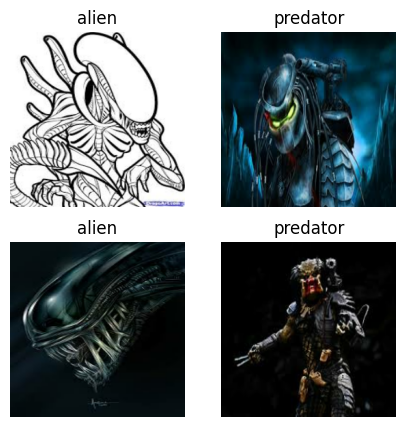

In [ ]:
display_random_images(ds_train_flipped)

# Models

In [ ]:
num_classes = len(ds_train.class_names)
input_shape = (img_height, img_width, 3)

## Convolution neural networks

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),  
  RandomRotation(0.2), 
  RandomZoom(0.2),  
])

In [ ]:
model1 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model3 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model4 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
models = [model1, model2, model3, model4]
histories = []
results = []
early_stopping_monitor = EarlyStopping(patience=2)

for i, model in enumerate(models):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy', 'sparse_categorical_crossentropy'])
    
    history = model.fit(ds_train, epochs=50, callbacks=[early_stopping_monitor], validation_data=ds_val)
    result_val = model.evaluate(ds_val, verbose=0)
    histories.append(history)
    
    result_train = model.evaluate(ds_train, verbose=0)
    
    results.append({'Model_name': f'Model{i+1}',
                     'train_acc': result_train[1], 
                    'train_loss': result_train[0],
                     'val_acc': result_val[1], 
                    'val_loss': result_val[0],
                     })

df_results = pd.DataFrame(results)


Epoch 1/50
22/22 [==============================] - 6s 96ms/step - loss: 0.5967 - accuracy: 0.6888 - sparse_categorical_crossentropy: 0.5967 - val_loss: 0.5638 - val_accuracy: 0.6900 - val_sparse_categorical_crossentropy: 0.5638
Epoch 2/50
22/22 [==============================] - 2s 85ms/step - loss: 0.5166 - accuracy: 0.7478 - sparse_categorical_crossentropy: 0.5166 - val_loss: 0.5234 - val_accuracy: 0.7450 - val_sparse_categorical_crossentropy: 0.5234
Epoch 3/50
22/22 [==============================] - 2s 84ms/step - loss: 0.5153 - accuracy: 0.7594 - sparse_categorical_crossentropy: 0.5153 - val_loss: 0.5209 - val_accuracy: 0.7400 - val_sparse_categorical_crossentropy: 0.5209
Epoch 4/50
22/22 [==============================] - 2s 85ms/step - loss: 0.4896 - accuracy: 0.7709 - sparse_categorical_crossentropy: 0.4896 - val_loss: 0.6678 - val_accuracy: 0.6450 - val_sparse_categorical_crossentropy: 0.6678
Epoch 5/50
22/22 [==============================] - 3s 96ms/step - loss: 0.5241 - ac

In [ ]:
df_results

,Model_name,train_acc,train_loss,val_acc,val_loss
0,Model1,0.756484,0.487463,0.680,0.554909
1,Model2,0.721902,0.543895,0.660,0.672336
2,Model3,0.995677,0.024316,0.760,1.342387
3,Model4,0.753602,0.498930,0.725,0.579275


## Resnet50

In [ ]:
early_stopping_monitor = EarlyStopping(patience=2)
input_shape = (img_height, img_width, 3)
num_classes = 2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping_monitor])

train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
results = []
results.append({  'train_acc': train_acc, 
                    'train_loss': train_loss,
                     'val_acc': val_acc, 
                    'val_loss': val_loss,
                    'test_acc': test_acc, 
                    'test_loss': test_loss,
                     })
results_resnet = pd.DataFrame(results)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 16s 133ms/step - loss: 0.3158 - accuracy: 0.8543 - val_loss: 0.2437 - val_accuracy: 0.9130
Epoch 2/50
93/93 [==============================] - 10s 107ms/step - loss: 0.1328 - accuracy:

In [ ]:
results_resnet

,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss
0,0.991007,0.034739,0.934783,0.14888,0.905,0.226502


In [13]:
# Get the predicted labels and true labels for the test set
y_pred = model.predict(test_ds)
y_true = test_ds.classes

# Get the classification report for each label
report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=['Predator', 'Alien'])

print(report)

34/34 [==============================] - 66s 2s/step
              precision    recall  f1-score   support

    Predator       0.53      0.62      0.57       100
       Alien       0.55      0.46      0.50       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



In [14]:
test_files = test_ds.filepaths
test_labels = test_ds.classes
class_labels = list(test_ds.class_indices.keys())

In [19]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(test_labels, np.argmax(y_pred, axis=1))

print(f'Test accuracy: {test_acc:.2%}')

Test accuracy: 54.00%


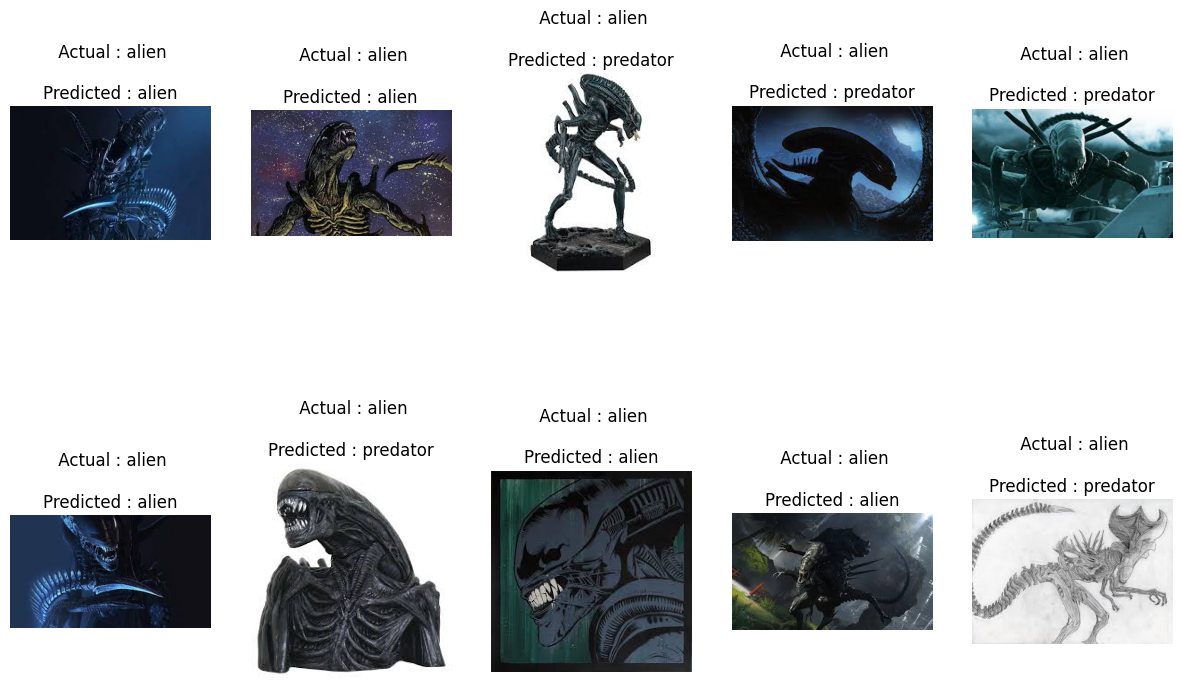

In [17]:
for i in range(10):
    plt.rcParams['figure.figsize'] = (15, 25)
    img = plt.imread(test_files[i])
    pred_label = np.argmax(y_pred[i])
    actual_label = y_true[i] 
    
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f" Actual : {class_labels[actual_label]}\n\nPredicted : {class_labels[pred_label]}")
    plt.axis('off')
    
plt.show()

In [ ]:
model.save('predator_alien_model.h5')

# Gradio app

In [9]:
# Load the saved model
model = tf.keras.models.load_model('predator_alien_model.h5')

# Define the labels
labels = ['Predator', 'Alien']

# Define a function to preprocess the image
def preprocess_image(img):
    # Convert the PIL image to a numpy array
    img_array = np.array(img)
    # Resize the image to the target size of 224x224
    img_array = cv2.resize(img_array, (224, 224))
    # Convert the pixel values to the range of 0-1
    img_array = img_array / 255.
    # Expand the dimensions of the array to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    # Return the preprocessed image
    return img_array


# Define a function to make predictions on the image
def predict_image(img):
    # Preprocess the image
    img_array = preprocess_image(img)
    # Make a prediction on the preprocessed image
    prediction = model.predict(img_array)
    # Get the index of the predicted class
    predicted_class = np.argmax(prediction)
    # Return the label for the predicted class
    return labels[predicted_class]

# Define the Gradio interface
image_input = gr.inputs.Image()
label_output = gr.outputs.Label()

# Define the Gradio app
gradio_app = gr.Interface(fn=predict_image, inputs=image_input, outputs=label_output, 
                          title='Alien vs Predator Classification', description='Upload an image to classify it as Alien or Predator')

# Run the Gradio app
gradio_app.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3247aea1897c3d65dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 10s 10s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3247aea1897c3d65dc.gradio.live
